In [1]:
from functions import *

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Après avoir récapituler le score de tous les modèles, l’algorithme de MultinomialNB() a eu le meilleur résultat avec un score Jacard de 0.70.

In [2]:
data = pd.read_csv("df_clean.csv",index_col=[0],low_memory=False)

In [3]:
df=data[['Lemm_Body','Lemm_Title','clean_Tags']].dropna()

In [4]:
X_Title = df.Lemm_Title
X_Body = df.Lemm_Body
y = df.clean_Tags

Fractionnement des données en train et test

In [5]:
X_Title_train, X_Title_test, y_Title_train, y_Title_test = train_test_split(X_Title, y, test_size = 0.3, random_state = 42)
X_Body_train, X_Body_test, y_Body_train, y_Body_test = train_test_split(X_Body, y, test_size = 0.3, random_state = 42)

In [6]:
print(X_Title_train.shape, X_Title_test.shape, y_Title_train.shape, y_Title_test.shape)
print(X_Body_train.shape, X_Body_test.shape, y_Body_train.shape, y_Body_test.shape)

(6998,) (3000,) (6998,) (3000,)
(6998,) (3000,) (6998,) (3000,)


### Prétraitement des colonnes 'Lemm_Body' et 'Lemm_Title'

In [7]:
# Initialisation du vectoriseur TF-IDF 
vectorizer_Title_tfidf = TfidfVectorizer(stop_words='english')
vectorizer_Body_tfidf= TfidfVectorizer(stop_words='english')

X_tfidf_Title_train = vectorizer_Title_tfidf.fit_transform(X_Title_train).toarray()
X_tfidf_Title_test = vectorizer_Title_tfidf.transform(X_Title_test).toarray()
feature_names_Title_tfidf = vectorizer_Title_tfidf.get_feature_names_out()

X_tfidf_Body_train = vectorizer_Body_tfidf.fit_transform(X_Body_train).toarray()
X_tfidf_Body_test = vectorizer_Body_tfidf.transform(X_Body_test).toarray()
feature_names_Body_tfidf = vectorizer_Body_tfidf.get_feature_names_out()


# Initialisation du vectoriseur CountVectorizer  
vectorizer_Title_cv = CountVectorizer(analyzer='word')
vectorizer_Body_cv = CountVectorizer(analyzer='word')

X_cv_Title_train = vectorizer_Title_cv.fit_transform(X_Title_train).toarray()
X_cv_Title_test = vectorizer_Title_cv.transform(X_Title_test).toarray()
feature_names_Title_cv = vectorizer_Title_cv.get_feature_names_out()

X_cv_Body_train = vectorizer_Body_cv.fit_transform(X_Body_train).toarray()
X_cv_Body_test = vectorizer_Body_cv.transform(X_Body_test).toarray()
feature_names_Body_cv = vectorizer_Body_cv.get_feature_names_out()


### Préparation de la colone cible
#### Encoder les Tags en appliquant MultiLabelBinarizer pour constituer le target 

In [8]:
multilabel_binarizer_Title = MultiLabelBinarizer()

y_mlbl_Title_train = multilabel_binarizer_Title.fit_transform(y_Title_train)
y_mlbl_Title_test = multilabel_binarizer_Title.transform(y_Title_test)


multilabel_binarizer_Body = MultiLabelBinarizer()

y_mlbl_Body_train = multilabel_binarizer_Body.fit_transform(y_Body_train)
y_mlbl_Body_test = multilabel_binarizer_Body.transform(y_Body_test)


In [9]:
print("X_tfidf_Title_train" , X_tfidf_Title_train.shape)
print("X_tfidf_Title_test" , X_tfidf_Title_test.shape)
print("X_tfidf_Body_train" , X_tfidf_Body_train.shape)
print("X_tfidf_Body_test" , X_tfidf_Body_test.shape)
print("X_cv_Title_train" , X_cv_Title_train.shape)
print("X_cv_Title_test" , X_cv_Title_test.shape)
print("X_cv_Body_train" , X_cv_Body_train.shape)
print("X_cv_Body_test" , X_cv_Body_test.shape)

print("y_mlbl_Title_train" , y_mlbl_Title_train.shape)
print("y_mlbl_Title_test" , y_mlbl_Title_test.shape)
print("y_mlbl_Body_train" , y_mlbl_Body_train.shape)
print("y_mlbl_Body_test" , y_mlbl_Body_test.shape)

X_tfidf_Title_train (6998, 5826)
X_tfidf_Title_test (3000, 5826)
X_tfidf_Body_train (6998, 44432)
X_tfidf_Body_test (3000, 44432)
X_cv_Title_train (6998, 5848)
X_cv_Title_test (3000, 5848)
X_cv_Body_train (6998, 44473)
X_cv_Body_test (3000, 44473)
y_mlbl_Title_train (6998, 41)
y_mlbl_Title_test (3000, 41)
y_mlbl_Body_train (6998, 41)
y_mlbl_Body_test (3000, 41)




#### J’ai décidé alors de aller plus loin et améliorer le résultat avec une recherche des hyperparamètres avec GridSearchCV  


In [10]:
#pickled_model = pickle.load(open('model.pkl', 'rb'))

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import jaccard_score

# Exemple de données
documents = X_Title_train
labels = y_Title_train

# Création du vecteur de features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

# Création du modèle MultinomialNB
model = MultinomialNB()

# Définition des hyperparamètres à rechercher
parameters = {'alpha': [0.1, 0.5, 1.0]}

# Recherche des hyperparamètres optimaux avec GridSearchCV
grid_search = GridSearchCV(model, parameters, scoring='accuracy', cv=5)
grid_search.fit(X, labels)

# Meilleur modèle avec les hyperparamètres optimaux
best_model = grid_search.best_estimator_

# Calcul du score de Jaccard sur les données d'entraînement
predictions = best_model.predict(X)
jaccard_score_train = jaccard_score(labels, predictions, average='micro')

print("Score de Jaccard sur les données d'entraînement :", jaccard_score_train)

# Nouvelle phrase à prédire
new_phrase = lemmatize(clean_text("m using jdk 15 (tried using 17, 16 and 11, same error).When I check my annotation processor in intelliJ, I see there is a processor path with lombok version 1.18.16. I don't know if this might be the issue, but when I delete the cache in .gradle folder, after building, it pops up again. Here is a screenshot."))

# Transformation de la nouvelle phrase en vecteur de features
new_X = vectorizer.transform([new_phrase])

# Prédiction des mots-clés avec le meilleur modèle
new_predictions = best_model.predict(new_X)
new_predictions.tolist()

# Affichage des mots-clés prédits
#keywords = vectorizer.inverse_transform(new_predictions)
#print("Mots-clés prédits :", keywords)

Score de Jaccard sur les données d'entraînement : 0.9951532430506058


['java hibernate orm jpa jpa-2.0']

### On va sauvegarder et transférer le modèle et le vectorizer  vers la platform d’hébergement StreamLit,    

In [ ]:
import pandas as pd
import pickle
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

def save_model(model,vectorizer):
    # saving model
    pickle.dump(best_model, open('model.pkl', 'wb'))
    pickle.dump(vectorizer, open('vectorizer.pickle', "wb"))

save_model(best_model, vectorizer)

# Voici le lien vers le logiciel publié en ligne chez Streamlit

https://levikshahmi-projet5shahmirrian-levik-3-programme-062023-kcct5z.streamlit.app/


#### Voud devez d'abbord cherger le modèle et le vectorizer, et ensuite poser votre question dans les zones de saisie
#### Ensuite valider pour que le logiciel vous propose des tags  

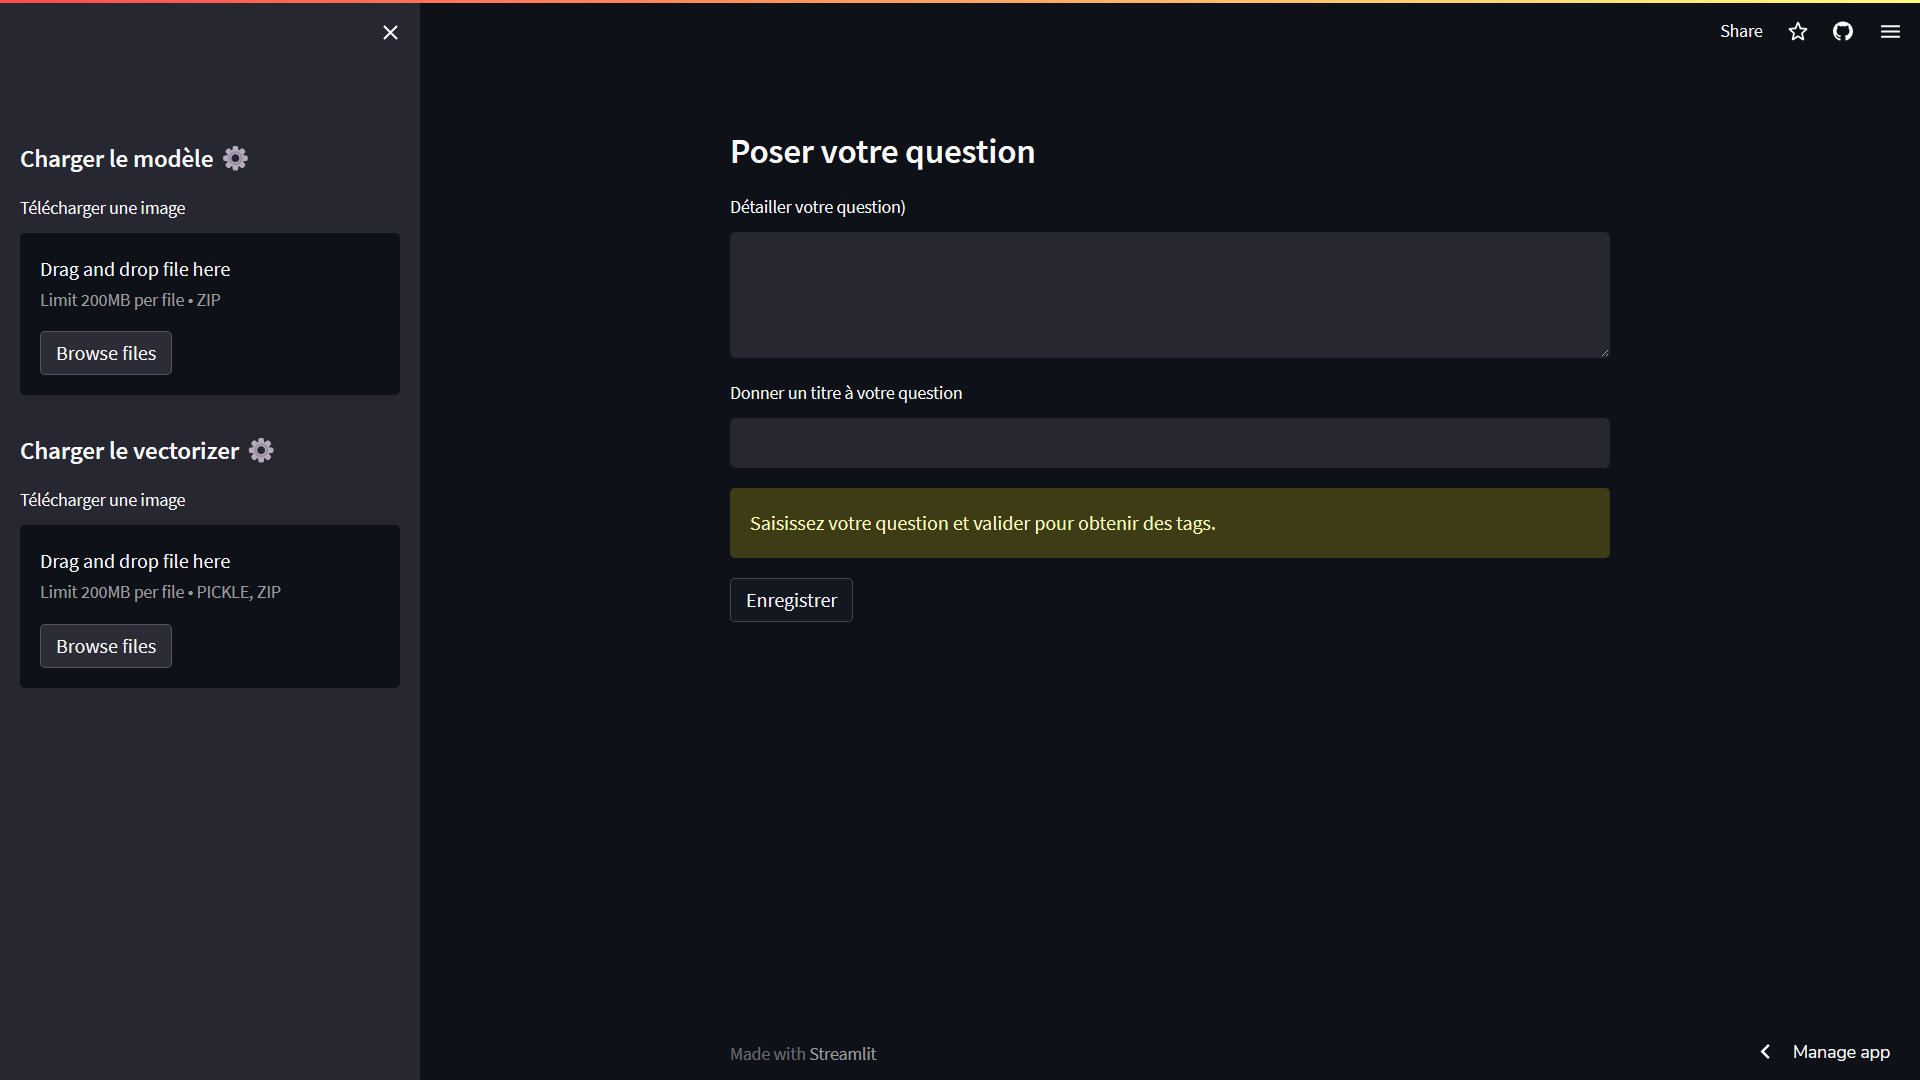